In [1]:
import matplotlib.pyplot as plt
from strategies import SimpleRSIStrategy
from volume_based_indicator import *

# Initial settings
transaction_currency =  "ETH"
counter_currency = "BTC"
end_time = 1531699200
start_time = end_time - 60 * 60 * 24 * 45
horizon = Horizon.short
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# fill kwargs structure, needed later
kwargs = {}
kwargs['source'] = source
kwargs['transaction_currency'] = transaction_currency
kwargs['counter_currency'] = counter_currency
kwargs['start_time'] = start_time
kwargs['end_time'] = end_time
kwargs['horizon'] = horizon
kwargs['resample_period'] = resample_period

price_volume_df = build_resampled_price_volume_df(start_time, end_time, transaction_currency, counter_currency, resample_period, source)

write_to_excel(price_volume_df, "df.xlsx")

DatabaseError: Execution failed on sql 'SELECT volume, timestamp FROM indicator_volume WHERE transaction_currency = %s AND counter_currency = %s 
                         AND source = %s AND timestamp >= %s AND timestamp <= %s ORDER BY timestamp ASC': relation "indicator_volume" does not exist
LINE 1: SELECT volume, timestamp FROM indicator_volume WHERE transac...
                                      ^


In [30]:
# First test of a VBI-based strategy
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, 0,0, 
                                                                    buy_only_on_first_cross=True, sell_strategy=None, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)

In [31]:
# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-02 16:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.854381 ETH 	 (1 ETH = 0.07760000 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-02 16:00:00 rsi_value=0
2018-06-19 12:08:00  	 OrderType.SELL   	 cash_balance ->          1.02 BTC 	 currency_balance ->    -12.854381 ETH 	 (1 ETH = 0.07967969 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-06-19 12:08:00 rsi_value=77.2212983395951
2018-06-21 07:00:00  	 OrderType.BUY    	 cash_balance ->         -1.02 BTC 	 currency_balance ->     12.715500 ETH 	 (1 ETH = 0.08014772 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

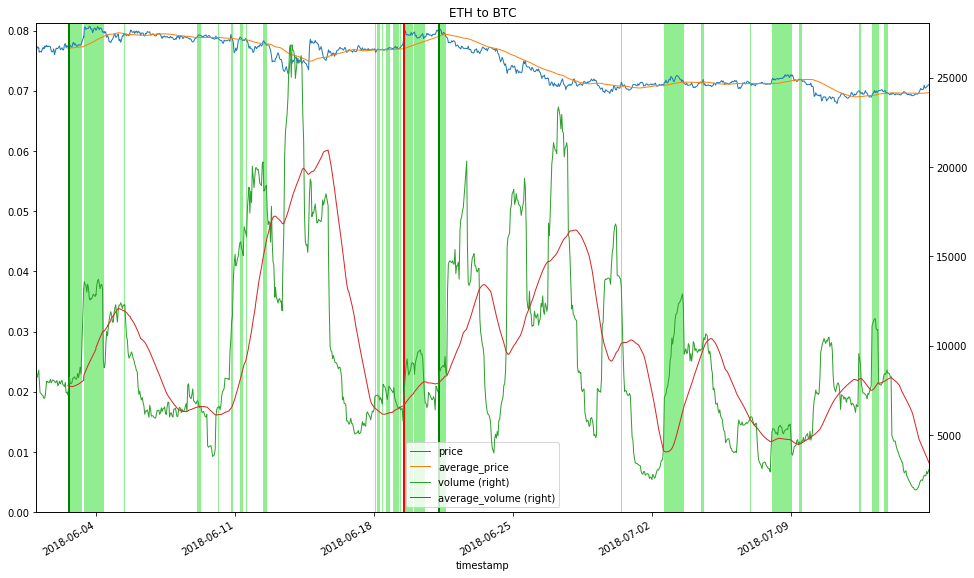

,price,average_price,volume,average_volume
timestamp,,,,
2018-06-01 00:00:00+00:00,0.076825,NaN,8394.317723,NaN
2018-06-01 00:19:00+00:00,0.076820,NaN,8314.118889,NaN
2018-06-01 01:05:00+00:00,0.077334,NaN,8244.645570,NaN
2018-06-01 02:31:00+00:00,0.077133,NaN,8540.949069,NaN
2018-06-01 03:00:00+00:00,0.077160,NaN,8647.849383,NaN
2018-06-01 03:24:00+00:00,0.076419,NaN,8209.255548,NaN
2018-06-01 04:31:00+00:00,0.076578,NaN,7387.601288,NaN
2018-06-01 05:55:00+00:00,0.076430,NaN,7318.318358,NaN
2018-06-01 06:26:00+00:00,0.076625,NaN,7277.615705,NaN


In [32]:
plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)

price_volume_df

Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-03 09:11:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.627116 ETH 	 (1 ETH = 0.07899666 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-03 09:11:00 rsi_value=0
2018-06-19 12:08:00  	 OrderType.SELL   	 cash_balance ->          1.00 BTC 	 currency_balance ->    -12.627116 ETH 	 (1 ETH = 0.07967969 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-06-19 12:08:00 rsi_value=77.2212983395951
2018-06-19 13:04:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     12.597964 ETH 	 (1 ETH = 0.07946525 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

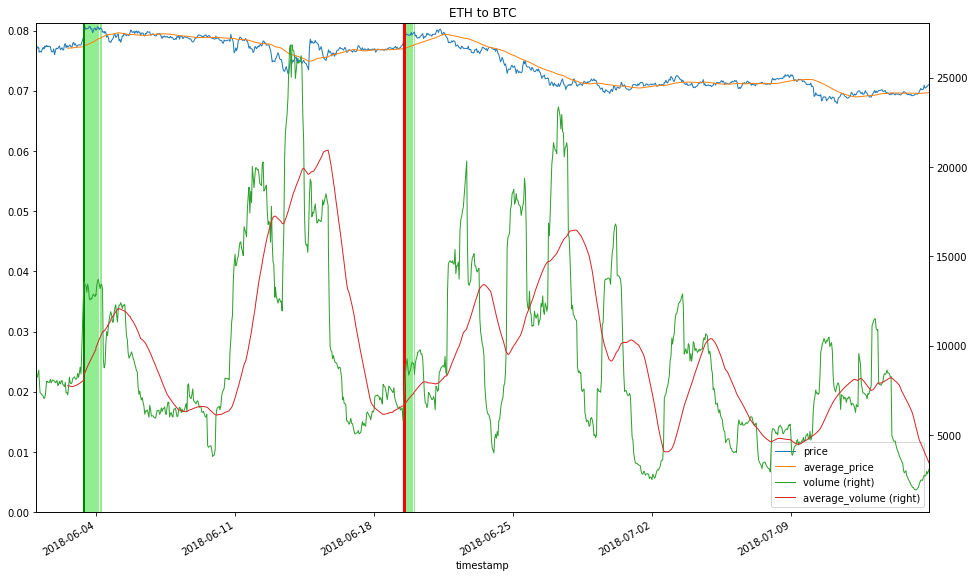

In [33]:
# Let's try another threshold
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, 0.02, 0.02, 
                                                                    buy_only_on_first_cross=True, sell_strategy=None, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)


# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

# Plot trades
plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)


In [34]:
overbought_threshold = 95
oversold_threshold = 25
sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                  overbought_threshold, oversold_threshold, 
                                  transaction_currency, "RSI", source)
profit_df = calculate_profits(price_volume_df, start_cash, start_crypto, sell_strategy, **kwargs)

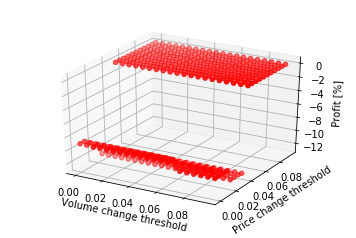

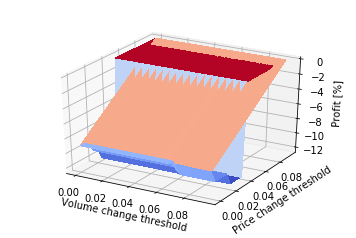

In [35]:
plot_profit_df(profit_df)

In [36]:
def write_to_excel(df, path):
    writer = pd.ExcelWriter(path)
    df.to_excel(writer,"Results")
    writer.save()

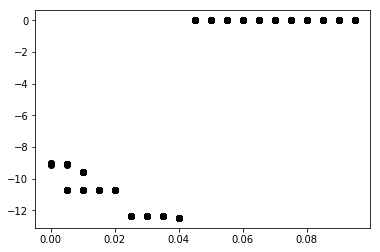

In [37]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');

In [38]:
# Find best performing parameters
sorted_by_profit = profit_df.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent
399,0.095,0.095,0.000000
112,0.025,0.060,0.000000
294,0.070,0.070,0.000000
293,0.070,0.065,0.000000
292,0.070,0.060,0.000000
291,0.070,0.055,0.000000
290,0.070,0.050,0.000000
289,0.070,0.045,0.000000
149,0.035,0.045,0.000000
150,0.035,0.050,0.000000


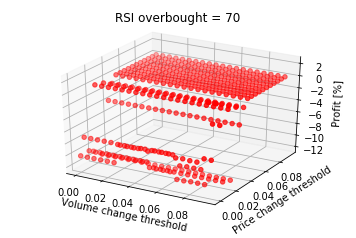

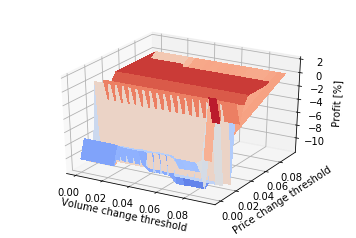

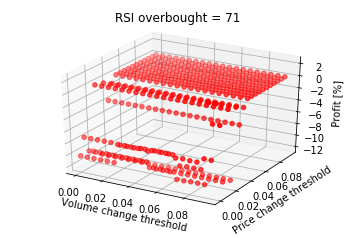

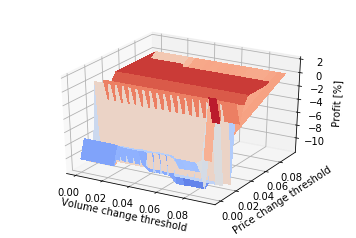

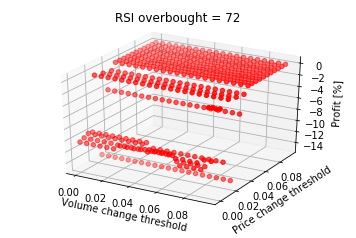

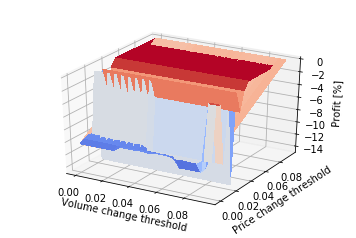

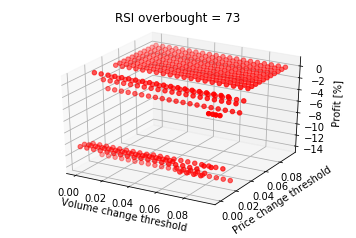

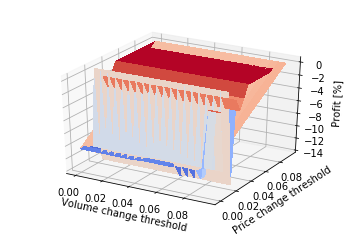

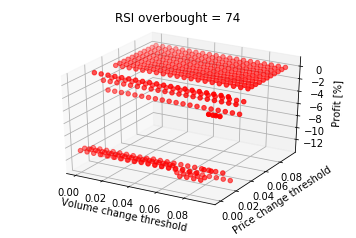

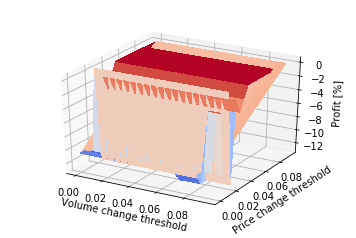

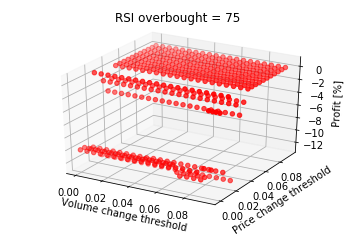

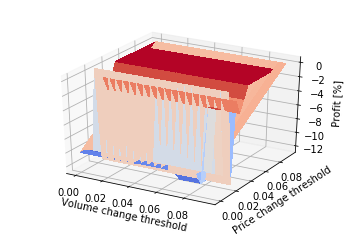

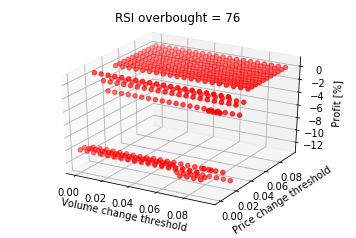

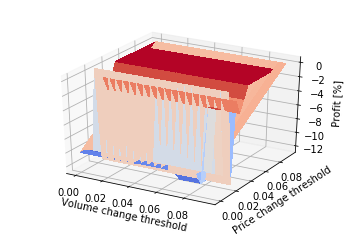

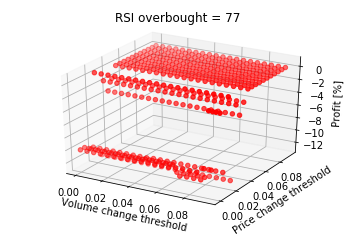

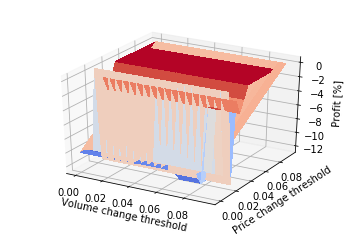

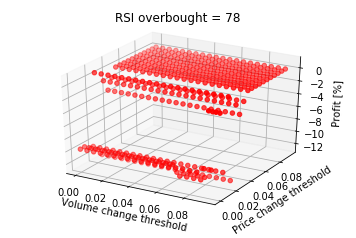

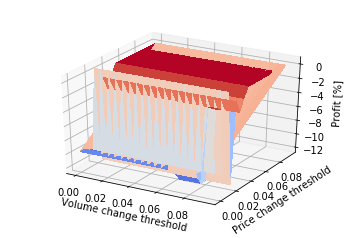

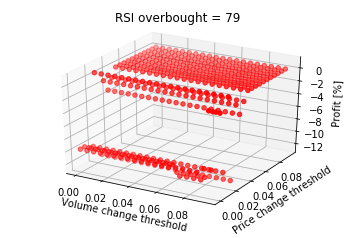

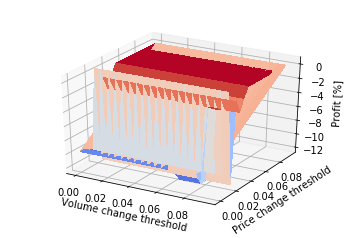

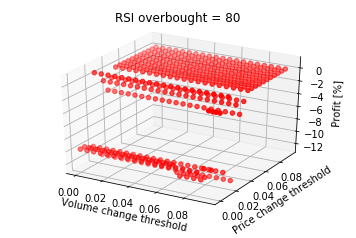

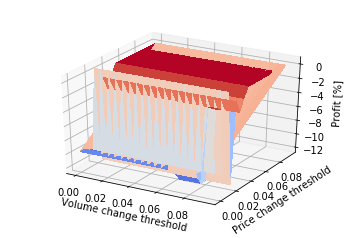

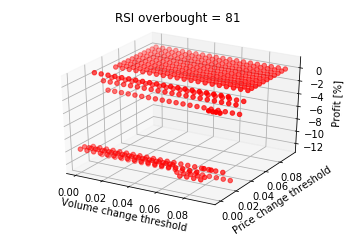

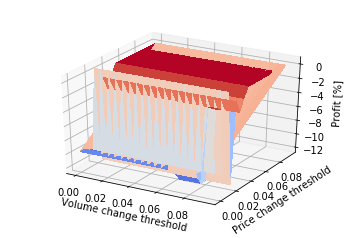

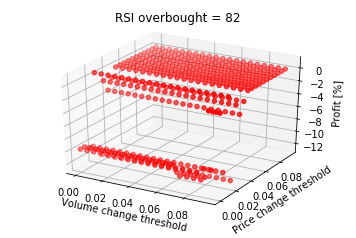

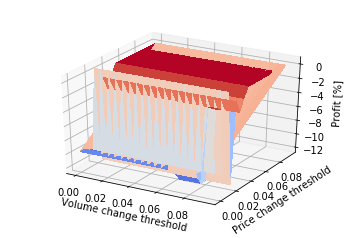

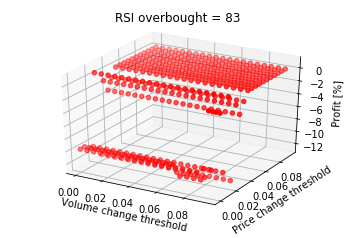

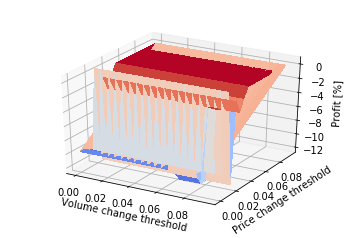

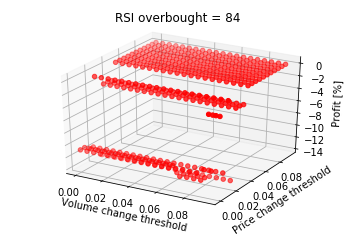

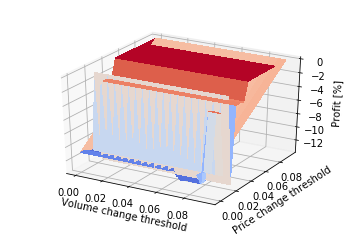

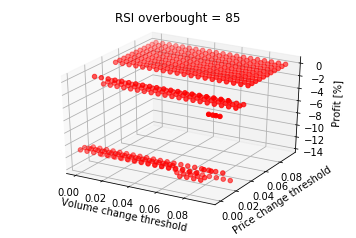

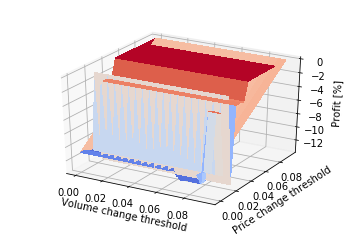

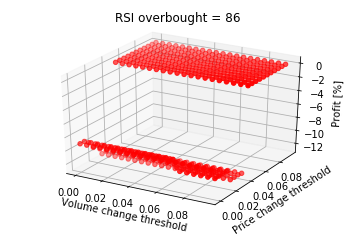

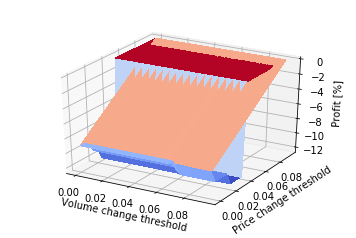

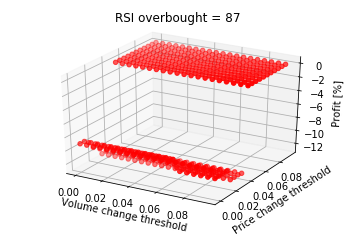

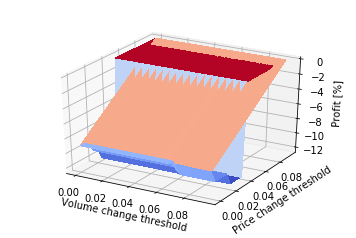

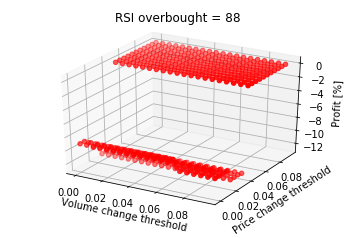

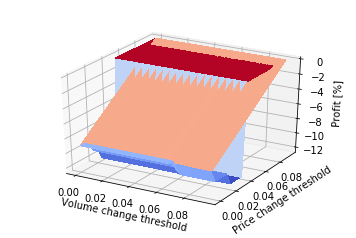

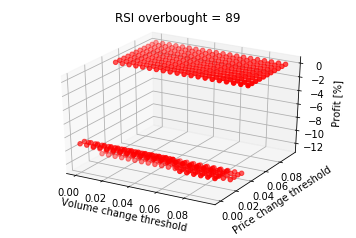

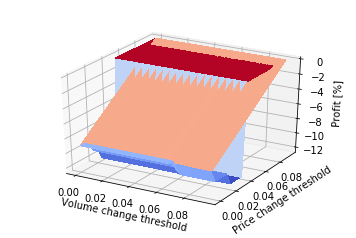

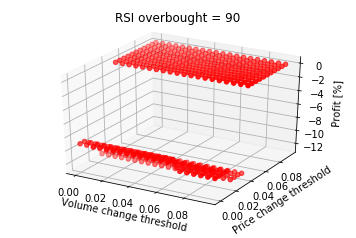

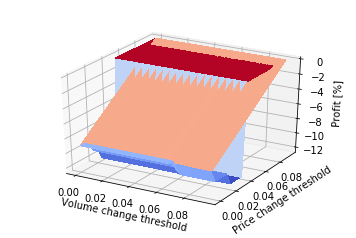

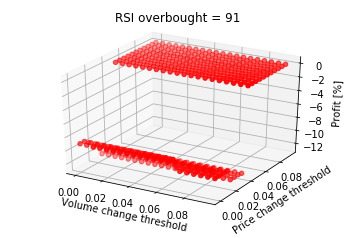

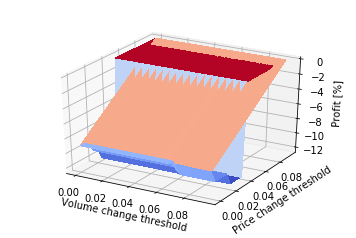

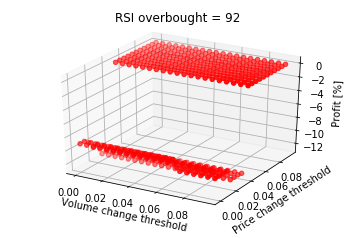

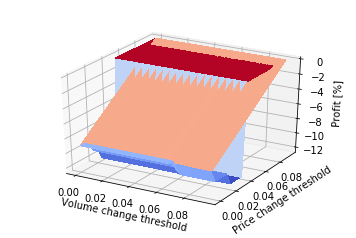

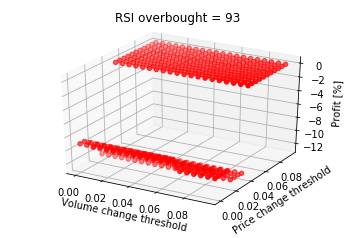

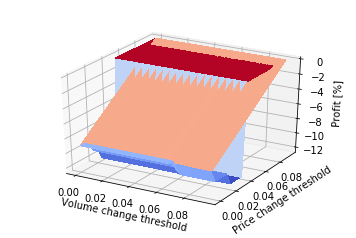

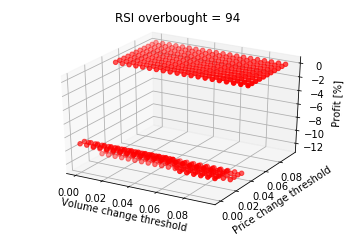

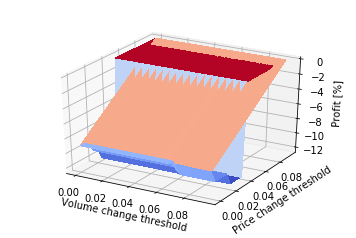

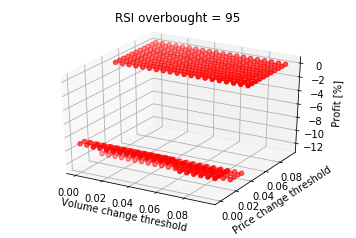

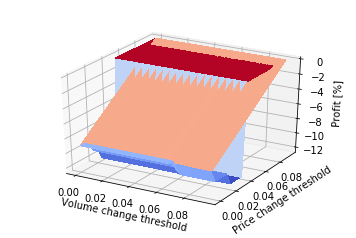

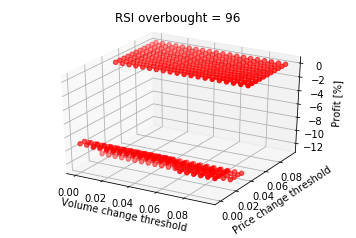

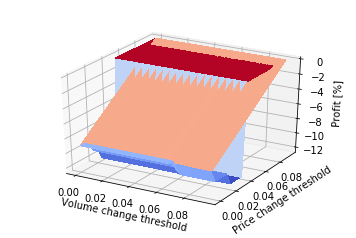

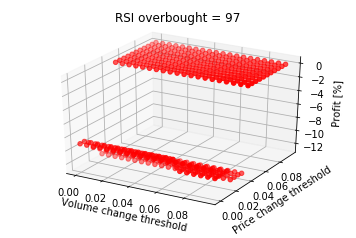

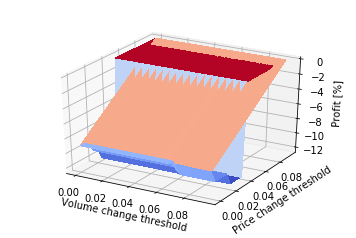

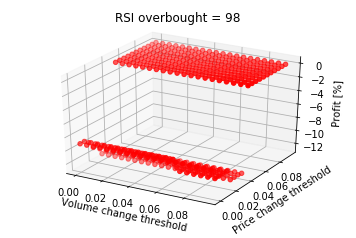

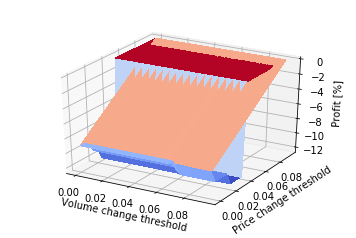

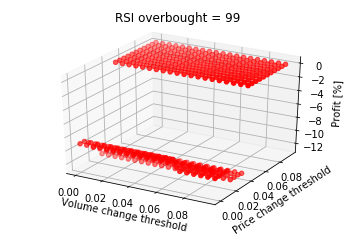

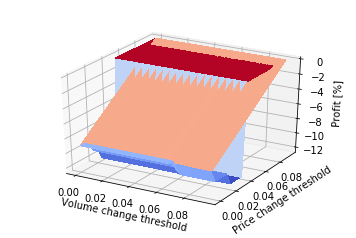

In [39]:
# Explore how RSI overbought influences the results
all_results = None
oversold_threshold = 20 # not used
for overbought_threshold in range(70,100):
    sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
    profit_df = calculate_profits(price_volume_df, start_cash, start_crypto, sell_strategy, **kwargs)
    profit_df['RSI overbought'] = pd.Series([overbought_threshold] * len(profit_df), index=profit_df.index)
    if all_results is None:
        all_results = profit_df
    else:
        all_results = all_results.append(profit_df, ignore_index=True)
    plot_profit_df(profit_df, "RSI overbought = {}".format(overbought_threshold))

In [24]:
all_results


,Volume change percent,Price change percent,Profit percent,RSI overbought
0,0.000,0.000,16.862532,70
1,0.000,0.005,19.890277,70
2,0.000,0.010,5.879957,70
3,0.000,0.015,25.378661,70
4,0.000,0.020,23.971944,70
5,0.000,0.025,21.077798,70
6,0.000,0.030,6.411911,70
7,0.000,0.035,-2.872925,70
8,0.000,0.040,-6.161576,70
9,0.000,0.045,-9.768074,70


In [25]:
sorted_by_profit = all_results.sort_values("Profit percent", inplace=False, ascending=False)
sorted_by_profit

,Volume change percent,Price change percent,Profit percent,RSI overbought
4063,0.015,0.015,30.788421,80
4064,0.015,0.020,30.788421,80
4282,0.070,0.010,30.742774,80
4043,0.010,0.015,30.714619,80
4024,0.005,0.020,30.714619,80
4023,0.005,0.015,30.714619,80
4004,0.000,0.020,30.714619,80
4003,0.000,0.015,30.714619,80
4044,0.010,0.020,30.714619,80
4283,0.070,0.015,30.447866,80


In [66]:
write_to_excel(all_results, "vbi_backtesting_btc_usdt.xlsx")

Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 80.0
  oversold_threshold = 20
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-08 12:05:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->    489.731593 ETC 	 (1 ETC = 0.00203683 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-06-08 12:05:00 rsi_value=0
2018-06-12 03:02:00  	 OrderType.SELL   	 cash_balance ->          1.10 BTC 	 currency_balance ->   -489.731593 ETC 	 (1 ETC = 0.00224951 BTC )
   signal: rsi_sell_3 strength=3 trend=-1 horizon=0 timestamp=2018-06-12 03:02:00 rsi_value=88.2615813154416
2018-06-16 14:03:00  	 OrderType.BUY    	 cash_balance ->         -1.10 BTC 	 currency_balance ->    493.761163 ETC 	 (1 ETC = 0.00222001 BTC )
   signal:

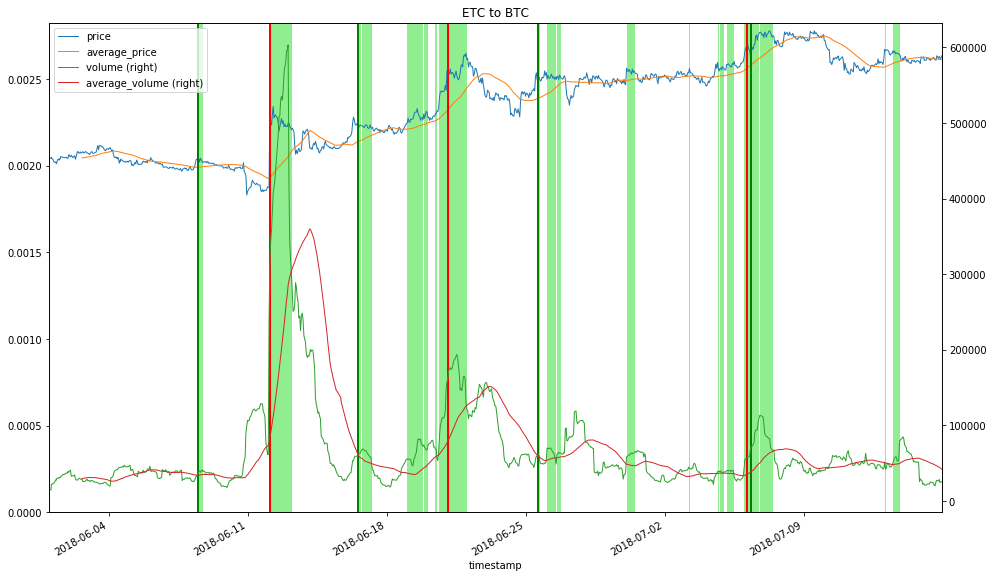

In [27]:
# Analyze the best parameter combination
overbought_threshold = sorted_by_profit.iloc[0]["RSI overbought"]
percent_change_volume = sorted_by_profit.iloc[0]["Volume change percent"]
percent_change_price = sorted_by_profit.iloc[0]["Price change percent"]


sell_strategy = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                                      overbought_threshold, oversold_threshold, 
                                      transaction_currency, "RSI", source)
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(price_volume_df, percent_change_price,
                                                                                percent_change_volume,
                                                                                buy_only_on_first_cross=True,
                                                                                sell_strategy=sell_strategy, **kwargs)
orders, _ = strategy.get_orders(start_cash, start_crypto)
evaluation = strategy.evaluate(1, start_crypto, start_time, end_time, verbose=True)

plot_results(price_volume_df, transaction_currency, counter_currency, all_buy_signals,
             first_cross_buy_signals, orders, include_all_buy=True, include_first_cross=False, include_orders=True)

In [28]:
# Let's establish the buy and hold and RSI baselines
from strategies import BuyAndHoldTimebasedStrategy
bah = BuyAndHoldTimebasedStrategy(start_time, end_time, transaction_currency, counter_currency, source)
bah.evaluate(start_cash, start_crypto, start_time, end_time)
rsi_strat = SimpleRSIStrategy(start_time, end_time, horizon, counter_currency, 
                              75, 25, transaction_currency, "RSI", source)
rsi_strat.evaluate(start_cash, start_crypto, start_time, end_time)

--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-06-01 00:00:00
--
--
2018-06-01 00:00:00  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->    489.565747 ETC 	 (1 ETC = 0.00203752 BTC )
2018-07-16 00:00:00  	 OrderType.SELL   	 cash_balance ->          1.28 BTC 	 currency_balance ->   -489.565747 ETC 	 (1 ETC = 0.00261899 BTC )
End time: 2018-07-16 00:00:00

Summary
--
Number of trades: 2
End cash: 1.28 BTC
End crypto: 0.000000 ETC
Total value invested: 1 BTC
Total value after investment: 1.28 BTC (+27.90%)
Profit: 0.28 BTC
Total value invested: 7485.00 USDT (conversion on 2018-06-01 00:00:00)
Total value after investment: 8112.63 USDT (+8.39%) (conversion on 2018-07-16 00:00:00)
Profit: 627.63 USDT
Strategy: a simple RSI-based strategy
  description: selling when rsi_value >= overbought_threshold, buying when rsi_value <= oversold threshold 
Strategy settings:
  overbought_threshold = 75
  oversold_threshold = 25
  hori